# Multi-Chain HMC

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

# from visualization import plot_predictive
import seaborn as sns

# import subspace_inference.utils as utils
# from subspace_inference.posteriors import SWAG
# from subspace_inference import models, losses, utils
# from subspace_inference.models import MLP
from swag import data, models, utils, losses
from swag.posteriors import SWAG


from tqdm import tqdm

import os

torch.backends.cudnn.benchmark = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

import hamiltorch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def featurize(x):
    return torch.cat([x[:, None], x[:, None]**2], dim=1)

class RegNet(nn.Sequential):
    def __init__(self, dimensions, input_dim=1, output_dim=1, apply_var=True):
        super(RegNet, self).__init__()
        self.dimensions = [input_dim, *dimensions, output_dim]        
        for i in range(len(self.dimensions) - 1):
            self.add_module('linear%d' % i, torch.nn.Linear(self.dimensions[i], self.dimensions[i + 1]))
            if i < len(self.dimensions) - 2:
                self.add_module('relu%d' % i, torch.nn.ReLU())

        if output_dim == 2:
            self.add_module('var_split', SplitDim(correction=apply_var))

#     def forward(self, x):
#         return super().forward(x)

In [3]:
arr = np.load("data.npz") 
x = torch.from_numpy(arr['x'])
f = featurize(x)
y = torch.from_numpy(arr['y']) * 10

x_ = torch.from_numpy(arr['x_'])
f_ = featurize(x_)
y_ = torch.from_numpy(arr['y_']) * 10

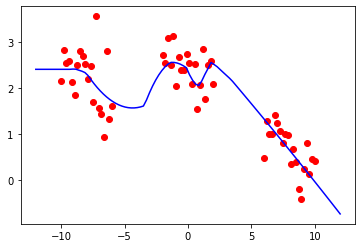

In [4]:
plt.plot(x.data.numpy(), y.data.numpy(), "ro")
plt.plot(x_.data.numpy(), y_.data.numpy(), "-b")

# Hypers

Noise Variance: $0.0005$
Prior Variance: $100$

In [20]:
n_chains = 200
n_samples_per_chain = 200

noise_var = 0.0005
prior_var = 100
pretrain_steps = 3000
    
step_size = 0.001
num_steps_per_sample = 10
tau_out = 1 / noise_var
tau_list = []
tau = 1 / prior_var
for w in net.parameters():
    tau_list.append(tau)
tau_list = torch.tensor(tau_list)

criterion = torch.nn.functional.mse_loss

all_preds_list = []

for i in range(n_chains):
    print(i)
    
    # Pre-Training for better burnin
    net = RegNet(dimensions=[10, 10, 10], input_dim=2)
    optimizer = torch.optim.SGD(net.parameters(), lr=5e-6)
    for epoch in range(pretrain_steps):
        optimizer.zero_grad()
        preds = net(f)
        loss = criterion(preds, y) / (2 * noise_var)
        loss.backward()
        optimizer.step()
    net.loss = 'regression'
    
    params_init = hamiltorch.util.flatten(net).clone()
    params_hmc = hamiltorch.sample_model(net, f, y, model_loss='regression', params_init=params_init, 
                                         num_samples=n_samples_per_chain, step_size=step_size, 
                                         num_steps_per_sample=num_steps_per_sample, tau_out=tau_out,
                                         tau_list=tau_list
                                        )
    
    pred_list, log_prob_list = hamiltorch.predict_model(net, f_, y_, samples=params_hmc, model_loss='regression', 
                                                    tau_out=1., tau_list=tau_list)

    all_preds_list.append(pred_list)
    
all_preds_list = np.vstack(all_preds_list)
np.save("hmc_ensembles_preds", all_preds_list)

0
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 59.06       
Acceptance Rate 0.78
1
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 58.04       
Acceptance Rate 0.83
2
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 57.85       
Acceptance Rate 0.87
3
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 57.02       
Acceptance Rate 0.78
4
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00

Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 58.26       
Acceptance Rate 0.67
39
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 58.47       
Acceptance Rate 0.74
40
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 58.59       
Acceptance Rate 0.74
41
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 58.15       
Acceptance Rate 0.57
42
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 58.08 

0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 57.78       
Acceptance Rate 0.83
77
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 58.19       
Acceptance Rate 0.83
78
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 58.07       
Acceptance Rate 0.89
79
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 58.12       
Acceptance Rate 0.85
80
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 57.87       
Acceptance Rate 0.81
81
Sampling (Sampler.HMC; Integrator.IMPLICIT

0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 57.41       
Acceptance Rate 0.78
153
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 58.37       
Acceptance Rate 0.78
154
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 58.49       
Acceptance Rate 0.77
155
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 58.15       
Acceptance Rate 0.74
156
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 58.39       
Acceptance Rate 0.85
157
Sampling (Sampler.HMC; Integrator.IMP

0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 57.11       
Acceptance Rate 0.82
191
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 57.67       
Acceptance Rate 0.82
192
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 57.21       
Acceptance Rate 0.84
193
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 57.55       
Acceptance Rate 0.88
194
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 | 57.45       
Acceptance Rate 0.81
195
Sampling (Sampler.HMC; Integrator.IMP

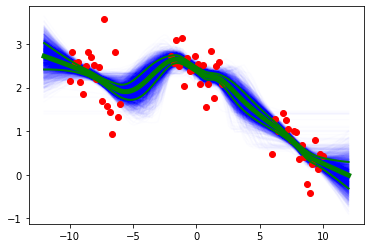

In [26]:
# all_preds = np.vstack([np.load("preds2_{}.npy".format(i)) for i in range(n_chains)])
all_preds = np.load("hmc_ensembles_preds.npy")

pred_mean = all_preds.mean(axis=0)
pred_std = all_preds.std(axis=0)
pred_upper = pred_mean + pred_std
pred_lower = pred_mean - pred_std

# plt.plot(x_ , all_preds[0, :, 0], '--k');
plt.plot(x_ , all_preds[::100, :, 0].T, '-b',alpha=0.01);
plt.plot(x.data.numpy(), y.data.numpy(), "ro")
# plt.plot(x_.data.numpy(), y_.data.numpy(), "--b")
plt.plot(x_.data.numpy(), pred_mean, "-g", lw=5)
plt.plot(x_.data.numpy(), pred_lower, "-g", lw=2)
plt.plot(x_.data.numpy(), pred_upper, "-g", lw=2)
# plt.ylim(-0.2, 0.4)